# 背景建模

# 1. 帧差法

① 前景就是一张图像中感兴趣的地方，背景就是一张图像中不太感兴趣的地方。

② 在一个视频中，更感兴趣的东西应该是运动的东西。

③ 由于场景中的目标在运动，目标的影像在不同图像帧中的位置不同。该类算法对时间上连续的两帧图像进行差分运算，不同帧对应的像素点相减，判断灰度差的绝对值，当绝对值超过一定阈值时，即可判断为运动目标，从而实现目标的检测功能。

④ 帧差法非常简单，但是会引入噪音和空洞问题。例如，人的稍微移动，衣服的中间区域移动前后的灰度值没有变化。

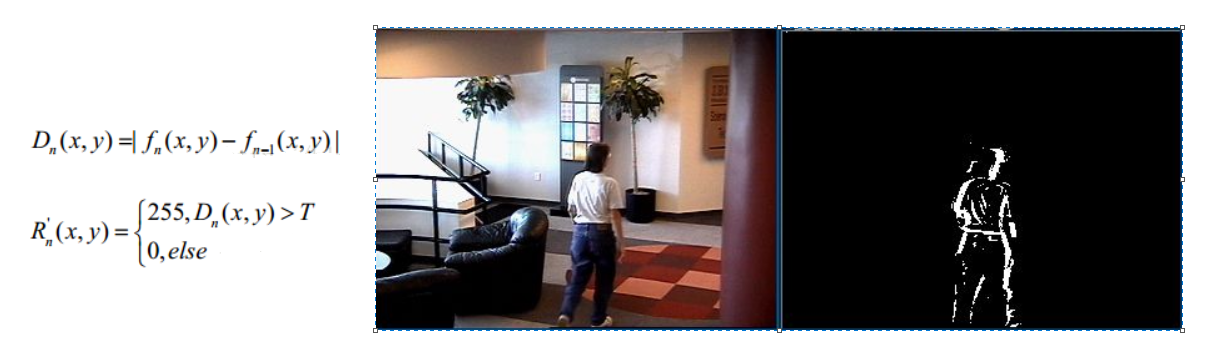

# 2. 混合高斯模型

① 在进行前景检测前，先对背景进行训练，对图像中每个背景采用一个混合高斯模型进行模拟，每个背景的混合高斯的个数可以自适应。

② 然后在测试阶段，对新来的像素进行 GMM 匹配，如果该像素值能够匹配其中一个高斯，则认为是背景，否则认为是前景。

③ 由于整个过程 GMM 模型在不断更新学习中，所以对动态背景有一定的鲁棒性。最后通过对一个有树枝摇摆的动态背景进行前景检测，取得了较好的效果。

④ 在视频中对于像素点的变化情况应当是符合高斯分布。

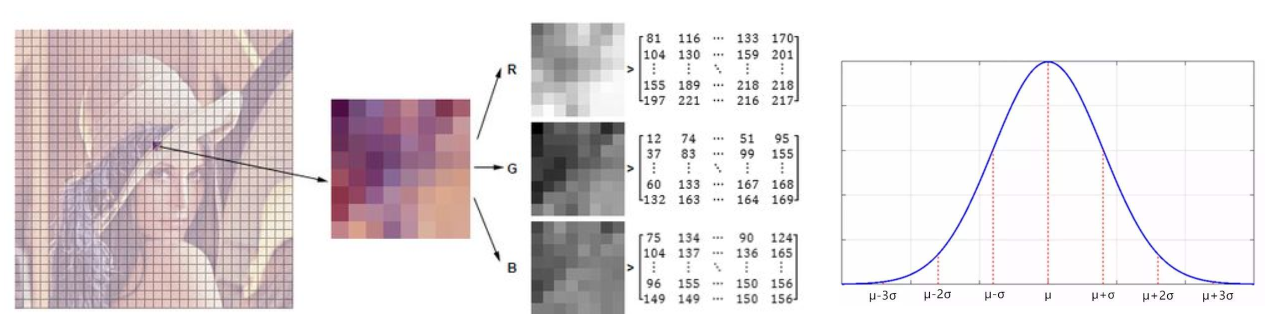

⑤ 背景的实际分布应当是多个高斯分布混合在一起，每个高斯模型也可以带有权重。

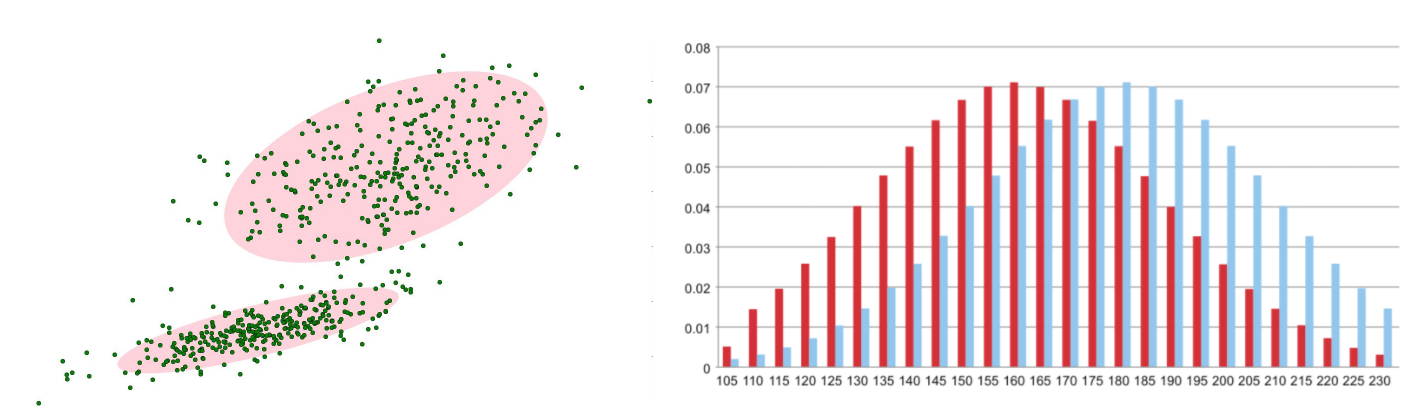

## 2.1  混合高斯模型学习方法

① 首先初始化每个高斯模型矩阵参数。

② 取视频中T帧数据图像用来训练高斯混合模型。来了第一个像素之后用它来当做第一个高斯分布。

③ 当后面来的像素值时，与前面已有的高斯的均值比较，如果该像素点的值与其模型均值差在3倍的方差内，则属于该分布，并对其进行参数更新。

④ 如果下一次来的像素不满足当前高斯分布，用它来创建一个新的高斯分布。

⑤ 默认设置 3-5 个混合的高斯分布模型。

## 2.2 混合高斯模型测试方法

① 在测试阶段，对新来像素点的值与混合高斯模型中的每一个均值进行比较，如果其差值在2倍的方差之间的话，则认为是背景，否则认为是前景。

② 将前景赋值为255，背景赋值为0。这样就形成了一副前景二值图。

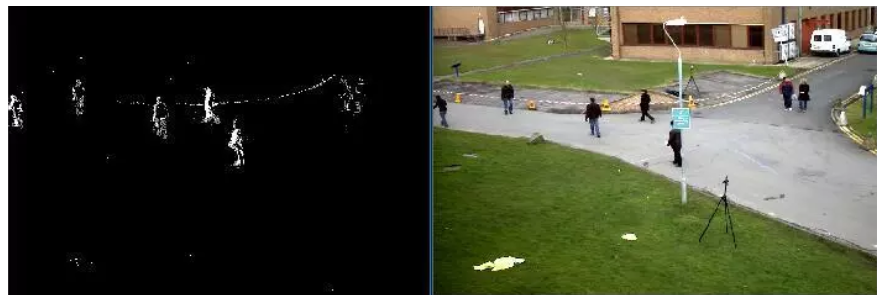

In [1]:
import numpy as np
import cv2

# 经典的测试视频
cap = cv2.VideoCapture('02_Video/01_Foreground.avi')

# 形态学操作需要使用
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
# 创建混合高斯模型用于背景建模
fgbg = cv2.createBackgroundSubtractorMOG2() # 混合高斯模型实例化对象
while(True):    
    ret,frame = cap.read()    
    fgmask = fgbg.apply(frame)    # 每一帧应用到混合高斯模型中
    # 形态学开运算去噪点
    fgmask = cv2.morphologyEx(fgmask,cv2.MORPH_OPEN,kernel)
    # 寻找视频中的轮廓
    im, contours, hierarchy = cv2.findContours(fgmask, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)    
    
    for c in contours:
        # 计算各轮廓的周长
        perimeter = cv2.arcLength(c,True)
        
        if perimeter > 188:
            # 找到一个直矩形 (不会旋转)
            x, y, w, h = cv2.boundingRect(c)
            # 画出这个矩形
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
            
    cv2.imshow('frame',frame)
    cv2.imshow('fgmask',fgmask)
    k = cv2.waitKey(150) & 0xff # 0xff 表示按退出键 ESC 就停止了
    if k == 27:
        break

cap.release()
cv2.destroyAllWindows()